# CNN 修改后

In [1]:
import sys
sys.path.append('D:\\Python\\lib\\site-packages')


import numpy as np
import os
import pickle

def load_cifar10(dataset="training_data", digits=np.arange(2), path="D:\1Ruanjian\Jupyter\cifar\cifar-10-batches-py"):
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    if dataset == "training_data":
        filenames = [os.path.join(path, 'data_batch_' + str(i)) for i in range(1, 6)]
    elif dataset == "test_data":
        filenames = [os.path.join(path, 'test_batch')]
    else:
        raise ValueError("dataset must be 'training_data' or 'test_data'")

    images = []
    labels = []
    for filename in filenames:
        batch = unpickle(filename)
        images.append(batch[b'data'])
        labels.extend(batch[b'labels'])

    images = np.concatenate(images)
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # convert to (N, 32, 32, 3)
    labels = np.array(labels)

    ind = [k for k in range(len(labels)) if labels[k] in digits]
    N = len(ind)
    selected_images = images[ind]
    selected_labels = labels[ind]

    return selected_images, selected_labels

def data_select(train_num, test_num, path="Invalid argument: 'D:\\x01Ruanjian\\Jupyter\\cifar\\cifar-10-batches-py'"):
    car, plane = 1, 0  # assuming 1 is car and 0 is plane
    x_train, y_train = load_cifar10("training_data", digits=[car, plane], path=path)
    x_test, y_test = load_cifar10("test_data", digits=[car, plane], path=path)
    
    # Train Leaving only labels car and plane
    idx_train = np.append(np.where(y_train == car)[0][:train_num], np.where(y_train == plane)[0][:train_num])
    x_train = x_train[idx_train]
    y_train = y_train[idx_train]
    x_train = x_train / 255.0
    y_train = np.eye(2)[y_train].reshape(-1, 2)
    
    # Test Leaving only labels car and plane
    idx_test = np.append(np.where(y_test == car)[0][:test_num], np.where(y_test == plane)[0][:test_num])
    x_test = x_test[idx_test]
    y_test = y_test[idx_test]
    x_test = x_test / 255.0
    y_test = np.eye(2)[y_test].reshape(-1, 2)
    
    return x_train, y_train, x_test, y_test
train_num=5000
test_num=1000
path = "D:\\1Ruanjian\\Jupyter\\cifar\\cifar-10-batches-py"
x_train, y_train, x_test, y_test = data_select(train_num, test_num, path)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (10000, 32, 32, 3)
y_train shape: (10000, 2)
x_test shape: (2000, 32, 32, 3)
y_test shape: (2000, 2)


In [2]:
import os
import os.path
import gzip
import struct
import numpy as np
import sys
sys.path.insert(0,"../")
from pyvqnet.nn.module import Module
from pyvqnet.nn.linear import Linear
from pyvqnet.nn.conv import Conv2D
from pyvqnet.utils.storage import load_parameters, save_parameters
from pyvqnet.nn import activation as F
from pyvqnet.nn.pooling import MaxPool2D

from pyvqnet.nn.loss import SoftmaxCrossEntropy
from pyvqnet.nn.loss import CategoricalCrossEntropy
from pyvqnet.optim.sgd import SGD
from pyvqnet.optim.adam import Adam
from pyvqnet.data.data import data_generator
from pyvqnet.tensor import tensor
from pyvqnet.tensor.tensor import QTensor
from pyvqnet.qnn.quantumlayer import QuantumLayer
import pyqpanda as pq
import matplotlib.pyplot as plt
import matplotlib
import pickle
#经典模型
class CNN(Module):
    """
    Classical CNN
    """
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = Conv2D(input_channels=1,
                            output_channels=16,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding="valid")
        self.relu1 = F.ReLu()

        self.conv2 = Conv2D(input_channels=16,
                            output_channels=32,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding="valid")
        self.relu2 = F.ReLu()
        self.maxpool2 = MaxPool2D([2, 2], [2, 2], padding="valid")

        self.conv3 = Conv2D(input_channels=32,
                            output_channels=64,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding="valid")
        self.relu3 = F.ReLu()

        self.conv4 = Conv2D(input_channels=64,
                            output_channels=128,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding="valid")

        self.relu4 = F.ReLu()
        self.maxpool4 = MaxPool2D([2, 2], [2, 2], padding="valid")

        self.fc1 = Linear(input_channels=3200, output_channels=1024)
        self.fc2 = Linear(input_channels=1024, output_channels=128)
        self.fc3 = Linear(input_channels=128, output_channels=10)

    def forward(self, x):

        x = self.relu1(self.conv1(x))

        x = self.maxpool2(self.relu2(self.conv2(x)))

        x = self.relu3(self.conv3(x))

        x = self.maxpool4(self.relu4(self.conv4(x)))

        x = tensor.flatten(x, 1)
        x = F.ReLu()(self.fc1(x))

        x = F.ReLu()(self.fc2(x))

        x = self.fc3(x)

        return x
#加载数据
def load_cifar10(dataset="testing_data", digits=np.arange(10), path="D:\\1Ruanjian\\Jupyter\\cifar\\cifar-10-batches-py"):
    from array import array as pyarray
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    if dataset == "training_data":
        filenames = [os.path.join(path, 'data_batch_' + str(i)) for i in range(1, 6)]
    elif dataset == "testing_data":
        filenames = [os.path.join(path, 'test_batch')]
    else:
        raise ValueError("dataset must be 'training_data' or 'testing_data'")

    images = []
    labels = []
    for filename in filenames:
        batch = unpickle(filename)
        images.append(batch[b'data'])
        labels.extend(batch[b'labels'])

    images = np.concatenate(images)
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # convert to (N, 32, 32, 3)
    labels = np.array(labels)

    ind = [k for k in range(len(labels)) if labels[k] in digits]
    images = images[ind]
    labels = labels[ind]
    
    return images, labels
train_size = 50
eval_size = 2
EPOCHES = 10
def classcal_cnn_model_training():
    x_train, y_train = load_cifar10("training_data", digits=np.arange(10))
    x_test, y_test = load_cifar10("testing_data", digits=np.arange(10))

    x_train = x_train[:train_size]
    y_train = y_train[:train_size]
    x_test = x_test[:eval_size]
    y_test = y_test[:eval_size]

    x_train = x_train / 255
    x_test = x_test / 255
    y_train = np.eye(10)[y_train].reshape(-1, 10)
    y_test = np.eye(10)[y_test].reshape(-1, 10)

    model = CNN()

    optimizer = SGD(model.parameters(), lr=0.005)
    # loss_func = SoftmaxCrossEntropy()
    loss_func = CategoricalCrossEntropy()

    epochs = EPOCHES
    loss_list = []
    model.train()

    save_flag = True
    temp_loss = 0
    for epoch in range(1, epochs):
        total_loss = []
        for x, y in data_generator(x_train,y_train,batch_size=1,shuffle=True):

            x = x.reshape(-1, 1, 32, 32)
            optimizer.zero_grad()
            # Forward pass
            output = model(x)
            

            # Calculating loss
            print('y',y)
            print('output',output)
            # SoftmaxCrossEntropy(y,output)
            print('SoftmaxCrossEntropy()',)
            loss = loss_func(y, output)  # target output
            loss_np = np.array(loss.data)
            # Backward pass
            loss.backward()
            # Optimize the weights
            optimizer._step()

            total_loss.append(loss_np)

        loss_list.append(np.sum(total_loss) / len(total_loss))
        print("{:.0f} loss is : {:.10f}".format(epoch, loss_list[-1]))

        if save_flag:
            temp_loss = loss_list[-1]
            save_parameters(model.state_dict(), "./result/QCNN_TL_1.model")
            save_flag = False
        else:
            if temp_loss > loss_list[-1]:
                temp_loss = loss_list[-1]
                save_parameters(model.state_dict(), "./result/QCNN_TL_1.model")

if __name__ == "__main__":
    classcal_cnn_model_training()


y [[0 0 1 0 0 0 0 0 0 0]]
output [[ 0.0646466, 0.1017599,-0.0207056,-0.0228367,-0.068545 ,-0.0455516,
  -0.0141835, 0.1075105, 0.0737917,-0.0261074],
 [ 0.0713331, 0.100513 ,-0.0230564,-0.0205958,-0.0630712,-0.0426234,
  -0.0143245, 0.1128863, 0.0741637,-0.0333332],
 [ 0.064883 , 0.0977634,-0.0175471,-0.0170933,-0.0683773,-0.0440022,
  -0.012087 , 0.1058935, 0.0755749,-0.0306062]]
SoftmaxCrossEntropy()


RuntimeError: Incompatible dims ( FILE: C:\Users\by210194\Desktop\VQNet2.11.0\package\0307\py310\vqnet\src\tensor\nn\tensor_losses.cpp. LINE: 48. FUNC: tensorNN::softmax_cross_entropy_templates
)

## 修改1

In [15]:
import os
import os.path
import gzip
import struct
import numpy as np
import sys
sys.path.insert(0,"../")
from pyvqnet.nn.module import Module
from pyvqnet.nn.linear import Linear
from pyvqnet.nn.conv import Conv2D
from pyvqnet.utils.storage import load_parameters, save_parameters
from pyvqnet.nn import activation as F
from pyvqnet.nn.pooling import MaxPool2D

from pyvqnet.nn.loss import SoftmaxCrossEntropy
from pyvqnet.nn.loss import CategoricalCrossEntropy
from pyvqnet.optim.sgd import SGD
from pyvqnet.optim.adam import Adam
from pyvqnet.data.data import data_generator
from pyvqnet.tensor import tensor
from pyvqnet.tensor.tensor import QTensor
from pyvqnet.qnn.quantumlayer import QuantumLayer
import pyqpanda as pq
import matplotlib.pyplot as plt
import matplotlib
import pickle
# 经典模型
class CNN(Module):
    """
    Classical CNN
    """
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = Conv2D(input_channels=1,
                            output_channels=16,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding="valid")
        self.relu1 = F.ReLu()

        self.conv2 = Conv2D(input_channels=16,
                            output_channels=32,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding="valid")
        self.relu2 = F.ReLu()
        self.maxpool2 = MaxPool2D([2, 2], [2, 2], padding="valid")

        self.conv3 = Conv2D(input_channels=32,
                            output_channels=64,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding="valid")
        self.relu3 = F.ReLu()

        self.conv4 = Conv2D(input_channels=64,
                            output_channels=128,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding="valid")

        self.relu4 = F.ReLu()
        self.maxpool4 = MaxPool2D([2, 2], [2, 2], padding="valid")

        self.fc1 = Linear(input_channels=3200, output_channels=1024) # 这里 3200 = 128 * 5 * 5 (conv + pool结果)
        self.fc2 = Linear(input_channels=1024, output_channels=128)
        self.fc3 = Linear(input_channels=128, output_channels=10)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = self.relu3(self.conv3(x))
        x = self.maxpool4(self.relu4(self.conv4(x)))
        x = tensor.flatten(x, 1)
        x = F.ReLu()(self.fc1(x))
        x = F.ReLu()(self.fc2(x))
        x = self.fc3(x)

        return x

# 加载数据
def load_cifar10(dataset="testing_data", digits=np.arange(10), path="D:\\1Ruanjian\\Jupyter\\cifar\\cifar-10-batches-py"):
    from array import array as pyarray
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    if dataset == "training_data":
        filenames = [os.path.join(path, 'data_batch_' + str(i)) for i in range(1, 6)]
    elif dataset == "testing_data":
        filenames = [os.path.join(path, 'test_batch')]
    else:
        raise ValueError("dataset must be 'training_data' or 'testing_data'")

    images = []
    labels = []
    for filename in filenames:
        batch = unpickle(filename)
        images.append(batch[b'data'])
        labels.extend(batch[b'labels'])

    images = np.concatenate(images)
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # 转换为 (N, 32, 32, 3)
    labels = np.array(labels)
    ind = [k for k in range(len(labels)) if labels[k] in digits]
    images = images[ind]
    labels = labels[ind]
    
    return images, labels

train_size = 50
eval_size = 2
EPOCHES = 10

def classcal_cnn_model_training():
    x_train, y_train = load_cifar10("training_data", digits=np.arange(10))
    x_test, y_test = load_cifar10("testing_data", digits=np.arange(10))

    # 取子集
    x_train, y_train = x_train[:train_size], y_train[:train_size]
    x_test, y_test = x_test[:eval_size], y_test[:eval_size]

    # 归一化
    x_train, x_test = x_train / 255, x_test / 255

    # 独热编码标签
    y_train = np.eye(10)[y_train].reshape(-1, 10)
    y_test = np.eye(10)[y_test].reshape(-1, 10)

    model = CNN()

    optimizer = SGD(model.parameters(), lr=0.005)
    loss_func = CategoricalCrossEntropy()

    epochs = EPOCHES
    loss_list = []
    model.train()

    save_flag = True
    temp_loss = 0
    for epoch in range(1, epochs):
        total_loss = []
        
        for x, y in data_generator(x_train, y_train, batch_size=4, shuffle=True):
            x = x.reshape(-1, 1, 32, 32)
            optimizer.zero_grad()
            # 前向传播
            output = model(x)

            # 计算损失
            loss = loss_func(y, output)  # 目标输出
            loss_np = np.array(loss.data)
            # 反向传播
            loss.backward()
            # 优化权重
            optimizer._step()

            total_loss.append(loss_np)

        loss_list.append(np.sum(total_loss) / len(total_loss))
        print("{:.0f} loss is : {:.10f}".format(epoch, loss_list[-1]))

        if save_flag:
            temp_loss = loss_list[-1]
            save_parameters(model.state_dict(), "./result/QCNN_TL_1.model")
            save_flag = False
        else:
            if temp_loss > loss_list[-1]:
                temp_loss = loss_list[-1]
                save_parameters(model.state_dict(), "./result/QCNN_TL_1.model")

if __name__ == "__main__":
    classcal_cnn_model_training()

AssertionError: x channel and conv's weights channel should be same

In [12]:
y = [[0,0,0,0,0,0,0,0,1,0],[0,0,0,1,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0,0],[0,0,0,0.0,0,0,1,0,0]]
output = [[ 0.0245738,-0.0856641,-0.0245474,-0.1017981, 0.0855989, 0.110918 ,
   0.0194269,-0.0786183, 0.0338744,-0.0483453],
 [ 0.0233513,-0.0952804,-0.019417 ,-0.1067941, 0.0872185, 0.1170403,
   0.0059364,-0.0825694, 0.037267 ,-0.0446181],
 [ 0.0147185,-0.0941741,-0.0197315,-0.1173117, 0.0860428, 0.1220066,
   0.0073223,-0.078866 , 0.0278066,-0.0418996],
 [ 0.0229073,-0.0873763,-0.0171994,-0.1001667, 0.0937067, 0.1130296,
   0.0145633,-0.0690246, 0.0475732,-0.0429312],
 [ 0.0267016,-0.0808583,-0.0335877,-0.076227 , 0.0923054, 0.1154694,
   0.0579687,-0.0800329, 0.023145 ,-0.04861  ],
 [ 0.0250514,-0.0786898,-0.0340381,-0.0765063, 0.0895614, 0.1129173,
   0.0617306,-0.0791962, 0.0245413,-0.047136 ],
 [ 0.0337529,-0.0800291,-0.0389856,-0.0773364, 0.0957237, 0.1158508,
   0.0501834,-0.0736546, 0.0315574,-0.0422833],
 [ 0.0347772,-0.08011  ,-0.0368934,-0.0724848, 0.0965467, 0.1167065,
   0.0523083,-0.0754125, 0.031147 ,-0.0376339],
 [ 0.0357778,-0.0805833,-0.0371161,-0.0769785, 0.0960408, 0.1177464,
   0.0509608,-0.0754092, 0.0324591,-0.041511 ],
 [ 0.0273196,-0.0865968,-0.0283734,-0.0898346, 0.0951874, 0.1087222,
   0.0139983,-0.0744943, 0.0389825,-0.0403866],
 [ 0.0233607,-0.0854124,-0.0161323,-0.1001821, 0.0756465, 0.1184017,
   0.0194396,-0.0767316, 0.041874 ,-0.0581256],
 [ 0.0220402,-0.0857905,-0.0284002,-0.102409 , 0.0914696, 0.1134084,
   0.0129128,-0.0830115, 0.0358371,-0.0492103]]
# SoftmaxCrossEntropy(y,output)
SoftmaxCrossEntropy(y,output)

TypeError: __init__() takes at most 2 positional arguments (3 given)

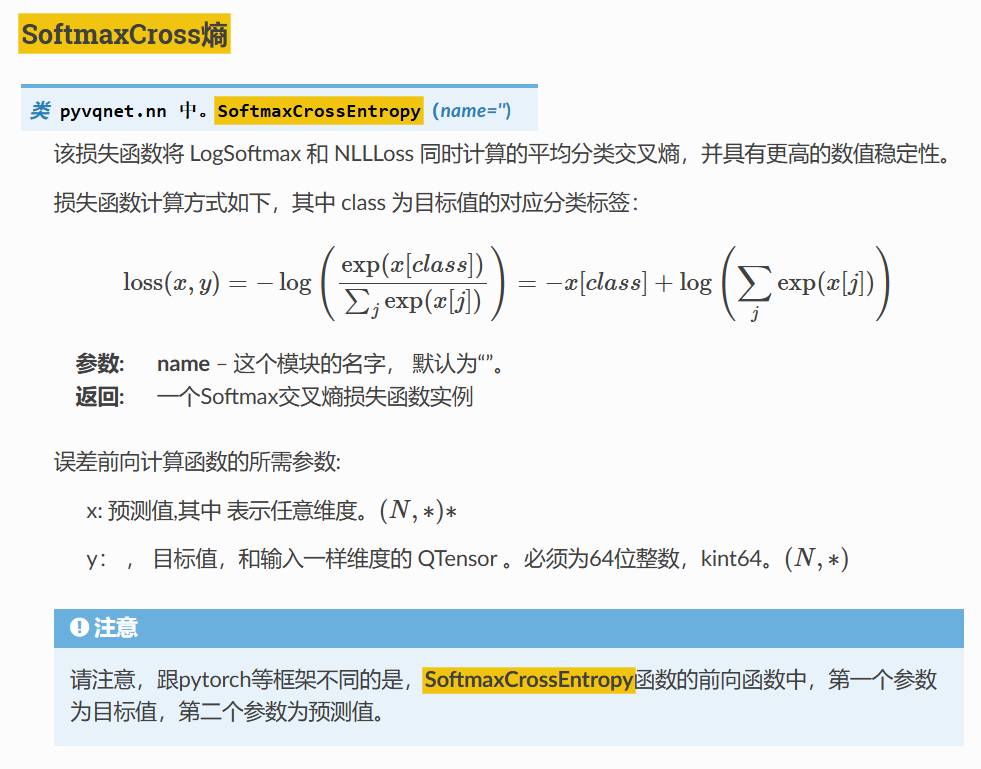

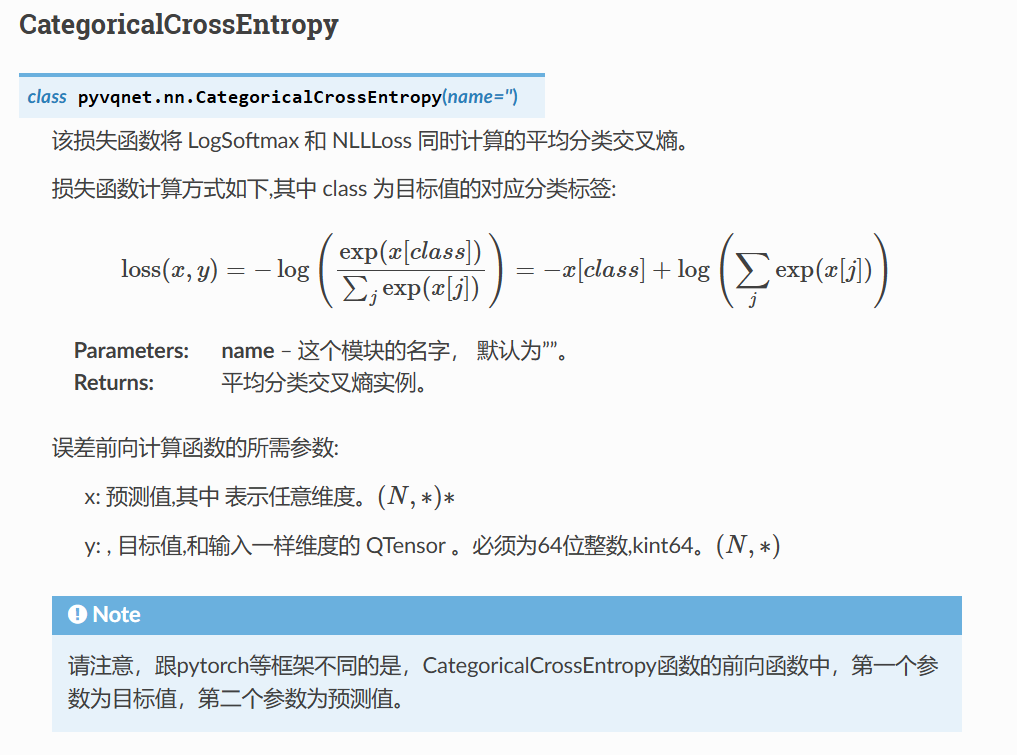

# QCNN 原文


In [4]:
"""
Quantum Classic Nerual Network Transfer Learning demo


"""

import os
import os.path
import gzip
import struct
import numpy as np
import sys
sys.path.insert(0,"../")
from pyvqnet.nn.module import Module
from pyvqnet.nn.linear import Linear
from pyvqnet.nn.conv import Conv2D
from pyvqnet.utils.storage import load_parameters, save_parameters
from pyvqnet.nn import activation as F
from pyvqnet.nn.pooling import MaxPool2D

from pyvqnet.nn.loss import SoftmaxCrossEntropy
from pyvqnet.optim.sgd import SGD
from pyvqnet.optim.adam import Adam
from pyvqnet.data.data import data_generator
from pyvqnet.tensor import tensor
from pyvqnet.tensor.tensor import QTensor
from pyvqnet.qnn.quantumlayer import QuantumLayer
import pyqpanda as pq
import matplotlib.pyplot as plt
import matplotlib
try:
    matplotlib.use("TkAgg")
except:  #pylint:disable=bare-except
    print("Can not use matplot TkAgg")
    pass

try:
    import urllib.request
except ImportError:
    raise ImportError("You should use Python 3.x")

url_base = "http://yann.lecun.com/exdb/mnist/"
key_file = {
    "train_img": "train-images-idx3-ubyte.gz",
    "train_label": "train-labels-idx1-ubyte.gz",
    "test_img": "t10k-images-idx3-ubyte.gz",
    "test_label": "t10k-labels-idx1-ubyte.gz"
}


def _download(dataset_dir, file_name):
    """
    Download dataset
    """
    file_path = dataset_dir + "/" + file_name

    if os.path.exists(file_path):
        with gzip.GzipFile(file_path) as file:
            file_path_ungz = file_path[:-3].replace("\\", "/")
            if not os.path.exists(file_path_ungz):
                open(file_path_ungz, "wb").write(file.read())
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    if os.path.exists(file_path):
        with gzip.GzipFile(file_path) as file:
            file_path_ungz = file_path[:-3].replace("\\", "/")
            file_path_ungz = file_path_ungz.replace("-idx", ".idx")
            if not os.path.exists(file_path_ungz):
                open(file_path_ungz, "wb").write(file.read())
    print("Done")


def download_mnist(dataset_dir):
    for v in key_file.values():
        _download(dataset_dir, v)

if not os.path.exists("./result"):
    os.makedirs("./result")
else:
    pass

class CNN(Module):
    """
    Classical CNN
    """
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = Conv2D(input_channels=1,
                            output_channels=16,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding="valid")
        self.relu1 = F.ReLu()

        self.conv2 = Conv2D(input_channels=16,
                            output_channels=32,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding="valid")
        self.relu2 = F.ReLu()
        self.maxpool2 = MaxPool2D([2, 2], [2, 2], padding="valid")

        self.conv3 = Conv2D(input_channels=32,
                            output_channels=64,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding="valid")
        self.relu3 = F.ReLu()

        self.conv4 = Conv2D(input_channels=64,
                            output_channels=128,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding="valid")

        self.relu4 = F.ReLu()
        self.maxpool4 = MaxPool2D([2, 2], [2, 2], padding="valid")

        self.fc1 = Linear(input_channels=128 * 4 * 4, output_channels=1024)
        self.fc2 = Linear(input_channels=1024, output_channels=128)
        self.fc3 = Linear(input_channels=128, output_channels=10)

    def forward(self, x):

        x = self.relu1(self.conv1(x))

        x = self.maxpool2(self.relu2(self.conv2(x)))

        x = self.relu3(self.conv3(x))

        x = self.maxpool4(self.relu4(self.conv4(x)))

        x = tensor.flatten(x, 1)
        x = F.ReLu()(self.fc1(x))

        x = F.ReLu()(self.fc2(x))

        x = self.fc3(x)

        return x


def load_mnist(dataset="training_data",
            digits=np.arange(2),
            path="./"):
    """
    Load mnist data
    """
    from array import array as pyarray
    download_mnist(path)
    if dataset == "training_data":
        fname_image = os.path.join(path, "train-images.idx3-ubyte").replace(
            "\\", "/")
        fname_label = os.path.join(path, "train-labels.idx1-ubyte").replace(
            "\\", "/")
    elif dataset == "testing_data":
        fname_image = os.path.join(path, "t10k-images.idx3-ubyte").replace(
            "\\", "/")
        fname_label = os.path.join(path, "t10k-labels.idx1-ubyte").replace(
            "\\", "/")
    else:
        raise ValueError("dataset must be 'training_data' or 'testing_data'")

    flbl = open(fname_label, "rb")
    _, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_image, "rb")
    _, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()

    ind = [k for k in range(size) if lbl[k] in digits]
    num = len(ind)
    images = np.zeros((num, rows, cols))
    labels = np.zeros((num, 1), dtype=int)
    for i in range(len(ind)):
        images[i] = np.array(img[ind[i] * rows * cols:(ind[i] + 1) * rows *
                                cols]).reshape((rows, cols))
        labels[i] = lbl[ind[i]]

    return images, labels


train_size = 50
eval_size = 2
EPOCHES = 10


def classcal_cnn_model_training():
    """
    load train data
    """

    x_train, y_train = load_mnist("training_data", digits=np.arange(10))
    x_test, y_test = load_mnist("testing_data", digits=np.arange(10))

    x_train = x_train[:train_size]
    y_train = y_train[:train_size]
    x_test = x_test[:eval_size]
    y_test = y_test[:eval_size]

    x_train = x_train / 255
    x_test = x_test / 255
    y_train = np.eye(10)[y_train].reshape(-1, 10)
    y_test = np.eye(10)[y_test].reshape(-1, 10)

    model = CNN()

    optimizer = SGD(model.parameters(), lr=0.005)
    loss_func = SoftmaxCrossEntropy()

    epochs = EPOCHES
    loss_list = []
    model.train()

    save_flag = True
    temp_loss = 0
    for epoch in range(1, epochs):
        total_loss = []
        for x, y in data_generator(x_train,
                                y_train,
                                batch_size=4,
                                shuffle=True):

            x = x.reshape(-1, 1, 28, 28)
            optimizer.zero_grad()
            # Forward pass
            output = model(x)

            # Calculating loss
            loss = loss_func(y, output)  # target output
            loss_np = np.array(loss.data)
            # Backward pass
            loss.backward()
            # Optimize the weights
            optimizer._step()

            total_loss.append(loss_np)

        loss_list.append(np.sum(total_loss) / len(total_loss))
        print("{:.0f} loss is : {:.10f}".format(epoch, loss_list[-1]))

        if save_flag:
            temp_loss = loss_list[-1]
            save_parameters(model.state_dict(), "./result/QCNN_TL_1.model")
            save_flag = False
        else:
            if temp_loss > loss_list[-1]:
                temp_loss = loss_list[-1]
                save_parameters(model.state_dict(), "./result/QCNN_TL_1.model")

    model.eval()
    correct = 0
    n_eval = 0

    for x, y in data_generator(x_test, y_test, batch_size=4, shuffle=True):
        x = x.reshape(-1, 1, 28, 28)
        output = model(x)
        loss = loss_func(y, output)
        np_output = np.array(output.data, copy=False)
        mask = (np_output.argmax(1) == y.argmax(1))
        correct += np.sum(np.array(mask))
        n_eval += 1
    print(f"Eval Accuracy: {correct / n_eval}")

    n_samples_show = 6
    count = 0
    _, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))
    model.eval()
    for x, y in data_generator(x_test, y_test, batch_size=1, shuffle=True):
        if count == n_samples_show:
            break
        x = x.reshape(-1, 1, 28, 28)
        output = model(x)
        pred = QTensor.argmax(output, [1],False)
        axes[count].imshow(x[0].squeeze(), cmap="gray")
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(np.array(pred.data)))
        count += 1
    plt.show()


def classical_cnn_transferlearning_predict():
    """
    Use test data to eval classic NN model
    """
    x_test, y_test = load_mnist("testing_data", digits=np.arange(10))

    x_test = x_test[:eval_size]
    y_test = y_test[:eval_size]

    x_test = x_test / 255

    y_test = np.eye(10)[y_test].reshape(-1, 10)

    model = CNN()

    model_parameter = load_parameters("./result/QCNN_TL_1.model")
    model.load_state_dict(model_parameter)
    model.eval()
    correct = 0
    n_eval = 0

    for x, y in data_generator(x_test, y_test, batch_size=1, shuffle=True):
        x = x.reshape(-1, 1, 28, 28)
        output = model(x)

        np_output = np.array(output.data, copy=False)
        mask = (np_output.argmax(1) == y.argmax(1))
        correct += np.sum(np.array(mask))
        n_eval += 1

    print(f"Eval Accuracy: {correct / n_eval}")

    n_samples_show = 6
    count = 0
    _, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))
    model.eval()
    for x, y in data_generator(x_test, y_test, batch_size=1, shuffle=True):
        if count == n_samples_show:
            break
        x = x.reshape(-1, 1, 28, 28)
        output = model(x)
        pred = QTensor.argmax(output, [1],False)
        axes[count].imshow(x[0].squeeze(), cmap="gray")
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(np.array(pred.data)))
        count += 1
    plt.show()

n_qubits = 4  # Number of qubits
q_depth = 6  # Depth of the quantum circuit (number of variational layers)

def Q_H_layer(qubits, nqubits):#pylint:disable=invalid-name
    """Layer of single-qubit Hadamard gates.
    """
    circuit = pq.QCircuit()
    for idx in range(nqubits):
        circuit.insert(pq.H(qubits[idx]))
    return circuit

def Q_RY_layer(qubits, w):#pylint:disable=invalid-name
    """
    Layer of parametrized qubit rotations around the y axis.
    """
    circuit = pq.QCircuit()
    for idx, element in enumerate(w):
        circuit.insert(pq.RY(qubits[idx], element))
    return circuit

def Q_entangling_layer(qubits, nqubits):#pylint:disable=invalid-name
    """
    Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    circuit = pq.QCircuit()
    for i in range(0, nqubits - 1,
                    2):  # Loop over even indices: i=0,2,...N-2
        circuit.insert(pq.CNOT(qubits[i], qubits[i + 1]))
    for i in range(1, nqubits - 1,
                    2):  # Loop over odd indices:  i=1,3,...N-3
        circuit.insert(pq.CNOT(qubits[i], qubits[i + 1]))
    return circuit

def quantum_net(q_input_features, q_weights_flat, qubits, cubits,#pylint:disable=unused-argument
                machine):
    """
    The variational quantum circuit.
    """
    machine = pq.CPUQVM()
    machine.init_qvm()
    qubits = machine.qAlloc_many(n_qubits)
    circuit = pq.QCircuit()

    # Reshape weights
    q_weights = q_weights_flat.reshape([q_depth, n_qubits])

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    circuit.insert(Q_H_layer(qubits, n_qubits))

    # Embed features in the quantum node
    circuit.insert(Q_RY_layer(qubits, q_input_features))

    # Sequence of trainable variational layers
    for k in range(q_depth):
        circuit.insert(Q_entangling_layer(qubits, n_qubits))
        circuit.insert(Q_RY_layer(qubits, q_weights[k]))

    # Expectation values in the Z basis
    prog = pq.QProg()
    prog.insert(circuit)

    exp_vals = []
    for position in range(n_qubits):
        pauli_str = "Z" + str(position)
        pauli_map = pq.PauliOperator(pauli_str, 1)
        hamiltion = pauli_map.toHamiltonian(True)
        exp = machine.get_expectation(prog, hamiltion, qubits)
        exp_vals.append(exp)

    return exp_vals
def quantum_cnn_transferlearning():
    """
    The quantum cnn transferLearning model main function
    """


    class Q_DressedQuantumNet(Module):#pylint:disable=invalid-name
        """
        module implementing the *dressed* quantum net.
        """
        def __init__(self):
            """
            Definition of the *dressed* layout.
            """

            super().__init__()
            self.pre_net = Linear(128, n_qubits)
            self.post_net = Linear(n_qubits, 10)
            self.qlayer = QuantumLayer(quantum_net, q_depth * n_qubits,
                                    "cpu", n_qubits, n_qubits)

        def forward(self, input_features):
            """
            Defining how tensors are supposed to move through the *dressed* quantum
            net.
            """

            # obtain the input features for the quantum circuit
            # by reducing the feature dimension from 512 to 4
            pre_out = self.pre_net(input_features)
            q_in = tensor.tanh(pre_out) * np.pi / 2.0
            q_out_elem = self.qlayer(q_in)

            result = q_out_elem
            # return the two-dimensional prediction from the postprocessing layer
            return self.post_net(result)

    x_train, y_train = load_mnist("training_data",
                                digits=np.arange(10))  # 下载训练数据
    x_test, y_test = load_mnist("testing_data", digits=np.arange(10))
    x_train = x_train[:train_size]
    y_train = y_train[:train_size]
    x_test = x_test[:eval_size]
    y_test = y_test[:eval_size]

    x_train = x_train / 255
    x_test = x_test / 255
    y_train = np.eye(10)[y_train].reshape(-1, 10)
    y_test = np.eye(10)[y_test].reshape(-1, 10)

    model = CNN()
    model_param = load_parameters("./result/QCNN_TL_1.model")
    model.load_state_dict(model_param)

    loss_func = SoftmaxCrossEntropy()

    epochs = EPOCHES
    loss_list = []

    eval_losses = []

    model_hybrid = model
    print(model_hybrid)

    for param in model_hybrid.parameters():
        param.requires_grad = False

    model_hybrid.fc3 = Q_DressedQuantumNet()

    optimizer_hybrid = Adam(model_hybrid.fc3.parameters(), lr=0.001)
    model_hybrid.train()

    save_flag = True
    temp_loss = 0
    for epoch in range(1, epochs):
        total_loss = []
        for x, y in data_generator(x_train,
                                y_train,
                                batch_size=4,
                                shuffle=True):
            x = x.reshape(-1, 1, 28, 28)
            optimizer_hybrid.zero_grad()
            # Forward pass
            output = model_hybrid(x)

            loss = loss_func(y, output)  # target output
            loss_np = np.array(loss.data)
            # Backward pass
            loss.backward()
            # Optimize the weights
            optimizer_hybrid._step()
            total_loss.append(loss_np)

        loss_list.append(np.sum(total_loss) / len(total_loss))
        print("{:.0f} loss is : {:.10f}".format(epoch, loss_list[-1]))
        if save_flag:
            temp_loss = loss_list[-1]
            save_parameters(model_hybrid.fc3.state_dict(),
                            "./result/QCNN_TL_FC3.model")
            save_parameters(model_hybrid.state_dict(),
                            "./result/QCNN_TL_ALL.model")
            save_flag = False
        else:
            if temp_loss > loss_list[-1]:
                temp_loss = loss_list[-1]
                save_parameters(model_hybrid.fc3.state_dict(),
                                "./result/QCNN_TL_FC3.model")
                save_parameters(model_hybrid.state_dict(),
                                "./result/QCNN_TL_ALL.model")

        correct = 0
        n_eval = 0
        loss_temp = []
        for x1, y1 in data_generator(x_test,
                                    y_test,
                                    batch_size=4,
                                    shuffle=True):
            x1 = x1.reshape(-1, 1, 28, 28)
            output = model_hybrid(x1)
            loss = loss_func(y1, output)
            np_loss = np.array(loss.data)
            np_output = np.array(output.data, copy=False)
            mask = (np_output.argmax(1) == y1.argmax(1))
            correct += np.sum(np.array(mask))
            n_eval += 1
            loss_temp.append(np_loss)
        eval_losses.append(np.sum(loss_temp) / n_eval)
        print("{:.0f} eval loss is : {:.10f}".format(epoch, eval_losses[-1]))

    plt.title("model loss")
    plt.plot(loss_list, color="green", label="train_losses")
    plt.plot(eval_losses, color="red", label="eval_losses")
    plt.ylabel("loss")
    plt.legend(["train_losses", "eval_losses"])
    plt.savefig("qcnn_transfer_learning_classical")
    plt.show()
    plt.close()

    n_samples_show = 6
    count = 0
    _, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))
    model_hybrid.eval()
    for x, y in data_generator(x_test, y_test, batch_size=1, shuffle=True):
        if count == n_samples_show:
            break
        x = x.reshape(-1, 1, 28, 28)
        output = model_hybrid(x)
        pred = QTensor.argmax(output, [1],False)
        axes[count].imshow(x[0].squeeze(), cmap="gray")
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(np.array(pred.data)))
        count += 1
    plt.show()


def quantum_cnn_transferlearning_predict():
    """
    Eval quantum cnn transferlearning model on test data
    """
    n_qubits = 4  # Number of qubits
    q_depth = 6  # Depth of the quantum circuit (number of variational layers)

    def Q_H_layer(qubits, nqubits):#pylint:disable=invalid-name
        """Layer of single-qubit Hadamard gates.
        """
        circuit = pq.QCircuit()
        for idx in range(nqubits):
            circuit.insert(pq.H(qubits[idx]))
        return circuit

    def Q_RY_layer(qubits, w):#pylint:disable=invalid-name
        """Layer of parametrized qubit rotations around the y axis.
        """
        circuit = pq.QCircuit()
        for idx, element in enumerate(w):
            circuit.insert(pq.RY(qubits[idx], element))
        return circuit

    def Q_entangling_layer(qubits, nqubits):#pylint:disable=invalid-name
        """Layer of CNOTs followed by another shifted layer of CNOT.
        """
        # In other words it should apply something like :
        # CNOT  CNOT  CNOT  CNOT...  CNOT
        #   CNOT  CNOT  CNOT...  CNOT
        circuit = pq.QCircuit()
        for i in range(0, nqubits - 1,
                    2):  # Loop over even indices: i=0,2,...N-2
            circuit.insert(pq.CNOT(qubits[i], qubits[i + 1]))
        for i in range(1, nqubits - 1,
                    2):  # Loop over odd indices:  i=1,3,...N-3
            circuit.insert(pq.CNOT(qubits[i], qubits[i + 1]))
        return circuit

    def quantum_net(q_input_features, q_weights_flat, qubits, cubits,#pylint:disable=unused-argument
                    machine):
        """
        The variational quantum circuit.
        """
        machine = pq.CPUQVM()
        machine.init_qvm()
        qubits = machine.qAlloc_many(n_qubits)
        circuit = pq.QCircuit()

        # Reshape weights
        q_weights = q_weights_flat.reshape([q_depth, n_qubits])

        # Start from state |+> , unbiased w.r.t. |0> and |1>
        circuit.insert(Q_H_layer(qubits, n_qubits))

        # Embed features in the quantum node
        circuit.insert(Q_RY_layer(qubits, q_input_features))

        # Sequence of trainable variational layers
        for k in range(q_depth):
            circuit.insert(Q_entangling_layer(qubits, n_qubits))
            circuit.insert(Q_RY_layer(qubits, q_weights[k]))

        # Expectation values in the Z basis
        prog = pq.QProg()
        prog.insert(circuit)
        exp_vals = []
        for position in range(n_qubits):
            pauli_str = "Z" + str(position)
            pauli_map = pq.PauliOperator(pauli_str, 1)
            hamiltion = pauli_map.toHamiltonian(True)
            exp = machine.get_expectation(prog, hamiltion, qubits)
            exp_vals.append(exp)

        return exp_vals

    class Q_DressedQuantumNet(Module):
        """
        module implementing the *dressed* quantum net.
        """
        def __init__(self):
            """
            Definition of the *dressed* layout.
            """

            super().__init__()
            self.pre_net = Linear(128, n_qubits)
            self.post_net = Linear(n_qubits, 10)
            self.qlayer = QuantumLayer(quantum_net, q_depth * n_qubits,
                                    "cpu", n_qubits, n_qubits)

        def forward(self, input_features):
            """
            Defining how tensors are supposed to move through the *dressed* quantum
            net.
            """

            # obtain the input features for the quantum circuit
            # by reducing the feature dimension from 512 to 4
            pre_out = self.pre_net(input_features)
            q_in = tensor.tanh(pre_out) * np.pi / 2.0
            q_out_elem = self.qlayer(q_in)

            result = q_out_elem
            # return the two-dimensional prediction from the postprocessing layer
            return self.post_net(result)

    x_train, y_train = load_mnist("training_data",
                                digits=np.arange(10))
    x_test, y_test = load_mnist("testing_data", digits=np.arange(10))
    x_train = x_train[:2000]
    y_train = y_train[:2000]
    x_test = x_test[:500]
    y_test = y_test[:500]

    x_train = x_train / 255
    x_test = x_test / 255
    y_train = np.eye(10)[y_train].reshape(-1, 10)
    y_test = np.eye(10)[y_test].reshape(-1, 10)

    # The second method: unified storage and unified reading
    model = CNN()
    model_hybrid = model
    model_hybrid.fc3 = Q_DressedQuantumNet()
    for param in model_hybrid.parameters():
        param.requires_grad = False
    model_param_quantum = load_parameters("./result/QCNN_TL_ALL.model")

    model_hybrid.load_state_dict(model_param_quantum)
    model_hybrid.eval()

    loss_func = SoftmaxCrossEntropy()
    eval_losses = []

    correct = 0
    n_eval = 0
    loss_temp = []
    eval_batch_size = 4
    for x1, y1 in data_generator(x_test,
                                y_test,
                                batch_size=eval_batch_size,
                                shuffle=True):
        x1 = x1.reshape(-1, 1, 28, 28)
        output = model_hybrid(x1)
        loss = loss_func(y1, output)
        np_loss = np.array(loss.data)
        np_output = np.array(output.data, copy=False)
        mask = (np_output.argmax(1) == y1.argmax(1))
        correct += np.sum(np.array(mask))

        n_eval += 1
        loss_temp.append(np_loss)

    eval_losses.append(np.sum(loss_temp) / n_eval)
    print(f"Eval Accuracy: {correct / (eval_batch_size*n_eval)}")

    n_samples_show = 6
    count = 0
    _, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))
    model_hybrid.eval()
    for x, _ in data_generator(x_test, y_test, batch_size=1, shuffle=True):
        if count == n_samples_show:
            break
        x = x.reshape(-1, 1, 28, 28)
        output = model_hybrid(x)
        pred = QTensor.argmax(output, [1],False)
        axes[count].imshow(x[0].squeeze(), cmap="gray")
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(np.array(pred.data)))
        count += 1
    plt.show()


if __name__ == "__main__":

    if not os.path.exists("./result/QCNN_TL_1.model"):
        classcal_cnn_model_training()
        classical_cnn_transferlearning_predict()
    #train quantum circuits.

    quantum_cnn_transferlearning()
    #eval quantum circuits.
    quantum_cnn_transferlearning_predict()

HTTPError: HTTP Error 403: Forbidden

# 1

In [3]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
import gzip
import struct
import numpy as np
import sys
sys.path.insert(0,"../")
from pyvqnet.nn.module import Module
from pyvqnet.nn.linear import Linear
from pyvqnet.nn.conv import Conv2D
from pyvqnet.utils.storage import load_parameters, save_parameters
from pyvqnet.nn import activation as F
from pyvqnet.nn.pooling import MaxPool2D

from pyvqnet.nn.loss import CategoricalCrossEntropy
from pyvqnet.optim.sgd import SGD
from pyvqnet.optim.adam import Adam
from pyvqnet.data.data import data_generator
from pyvqnet.tensor import tensor
from pyvqnet.tensor.tensor import QTensor
from pyvqnet.qnn.quantumlayer import QuantumLayer
import pyqpanda as pq
import matplotlib.pyplot as plt
import matplotlib
import time
import numpy as np
import os
import pickle
#导入数据
def load_cifar10(dataset="testing_data", digits=np.arange(10), path="D:/Python/Lib/site-packages/cifar-10-batches-py"):
    from array import array as pyarray
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    if dataset == "training_data":
        filenames = [os.path.join(path, 'data_batch_' + str(i)) for i in range(1, 6)]
    elif dataset == "testing_data":
        filenames = [os.path.join(path, 'test_batch')]
    else:
        raise ValueError("dataset must be 'training_data' or 'testing_data'")

    images = []
    labels = []
    for filename in filenames:
        batch = unpickle(filename)
        images.append(batch[b'data'])
        labels.extend(batch[b'labels'])

    images = np.concatenate(images)
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # convert to (N, 32, 32, 3)
    labels = np.array(labels)

    ind = [k for k in range(len(labels)) if labels[k] in digits]
    images = images[ind]
    labels = labels[ind]
    
    return images, labels

def data_select(train_num, test_num, selectes_classes, path="D:/Python/Lib/site-packages/cifar-10-batches-py"):
    
    from array import array as pyarray
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    x_train, y_train = load_cifar10("training_data", digits=np.arange(10), path=path)
    x_test, y_test = load_cifar10("testing_data", digits=np.arange(10), path=path)
    
    x_train = x_train / 255.0
    x_test = x_test / 255.0
    
    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]
    
    return x_train, y_train, x_test, y_test
#从数据库中挑出6张图
n_samples_show = 6

x_train, y_train, x_test, y_test = data_select(1000, 100,[8,9])#可修改
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

counter = 0
for img, target in zip(x_test, y_test):
    if counter >= n_samples_show:
        break
    label = np.argmax(target)
    axes[counter].set_title("Labeled: {}".format(label))
    axes[counter].imshow(img, cmap='gray')
    axes[counter].set_xticks([])
    axes[counter].set_yticks([])
    counter += 1

plt.show()
#构建量子线路
from pyqpanda import *
import pyqpanda as pq
import numpy as np
def circuit(weights):
    num_qubits = 1
    #pyQPanda 创建模拟器
    machine = pq.CPUQVM()
    machine.init_qvm()
    #pyQPanda 分配量子比特
    qubits = machine.qAlloc_many(num_qubits)
    #pyQPanda 分配经典比特辅助测量
    cbits = machine.cAlloc_many(num_qubits)
    #构建线路
    circuit = pq.QCircuit()
    circuit.insert(pq.H(qubits[0]))
    circuit.insert(pq.RY(qubits[0], weights[0]))

    prog = pq.QProg()
    prog.insert(circuit)
    prog << measure_all(qubits, cbits)

    #运行量子程序
    result = machine.run_with_configuration(prog, cbits, 100)

    counts = np.array(list(result.values()))
    states = np.array(list(result.keys())).astype(float)
    probabilities = counts / 100
    expectation = np.sum(states * probabilities)
    return expectation

weights = [0.8]
result = circuit(weights)
print("Ecpectation value:", result)

#构建混合量子神经网络
#量子计算层的前传和梯度计算函数的定义，其需要继承于抽象类Module
class Hybrid(Module):
    """ Hybrid quantum - Quantum layer definition """
    def __init__(self, shift):
        super(Hybrid, self).__init__()
        self.shift = shift
    def forward(self, input):
        self.input = input
        expectation_z = circuit(np.array(input.data))
        result = [[expectation_z]]
        requires_grad = input.requires_grad
        def _backward(g, input):
            """ Backward pass computation """
            input_list = np.array(input.data)
            shift_right = input_list + np.ones(input_list.shape) * self.shift
            shift_left = input_list - np.ones(input_list.shape) * self.shift

            gradients = []
            for i in range(len(input_list)):
                expectation_right = circuit(shift_right[i])
                expectation_left = circuit(shift_left[i])

                gradient = expectation_right - expectation_left
                gradients.append(gradient)
            gradients = np.array([gradients]).T
            return gradients * np.array(g)

        nodes = []
        if input.requires_grad:
            nodes.append(QTensor.GraphNode(tensor=input, df=lambda g: _backward(g, input)))
        return QTensor(data=result, requires_grad=requires_grad, nodes=nodes)

#模型定义
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = Conv2D(input_channels=1, output_channels=6, kernel_size=(3, 3), stride=(1, 1), padding="same")
        self.maxpool1 = MaxPool2D([2, 2], [2, 2], padding="valid")
        self.conv2 = Conv2D(input_channels=6, output_channels=16, kernel_size=(3, 3), stride=(1, 1), padding="same")
        self.maxpool2 = MaxPool2D([2, 2], [2, 2], padding="valid")
        self.fc1 = Linear(input_channels=1024, output_channels=64)
        self.fc2 = Linear(input_channels=64, output_channels=1)
        self.hybrid = Hybrid(np.pi / 2)
        self.fc3 = Linear(input_channels=1, output_channels=10)

    def forward(self, x):
        x = F.ReLu()(self.conv1(x))  # 1 6 24 24
        x = self.maxpool1(x)
        x = F.ReLu()(self.conv2(x))  # 1 16 8 8
        x = self.maxpool2(x)
        x = tensor.flatten(x, 1)   # 1 256
        x = F.ReLu()(self.fc1(x))  # 1 64
        x = self.fc2(x)    # 1 1
        x = self.hybrid(x)
        x = self.fc3(x)
        #print(x.shape)
        return x

x_train, y_train, x_test, y_test = data_select(1000, 100, [0, 1])#可修改
#训练和测试
# 记录训练开始时刻
start_time = time.time()
#实例化
model = Net()
#使用Adam完成此任务就足够了，model.parameters（）是模型需要计算的参数。
optimizer = Adam(model.parameters(), lr=0.005)
#分类任务使用交叉熵函数
loss_func = CategoricalCrossEntropy()

#训练次数
epochs = 10
train_loss_list = []
val_loss_list = []
train_acc_list =[]
val_acc_list = []


for epoch in range(1, epochs):
    total_loss = []
    model.train()
    batch_size = 1
    correct = 0
    n_train = 0
    for x, y in data_generator(x_train, y_train, batch_size=1, shuffle=True):

        x = x.reshape(-1, 1, 32, 32)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_func(y, output)
        loss_np = np.array(loss.data)
        np_output = np.array(output.data, copy=False)
        mask = (np_output.argmax(1) == y.argmax(1))
        correct += np.sum(np.array(mask))
        n_train += batch_size
        loss.backward()
        optimizer._step()
        total_loss.append(loss_np)

    train_loss_list.append(np.sum(total_loss) / len(total_loss))
    train_acc_list.append(np.sum(correct) / n_train)
    print("{:.0f} loss is : {:.10f}".format(epoch, train_loss_list[-1]))

    model.eval()
    correct = 0
    n_eval = 0

    for x, y in data_generator(x_test, y_test, batch_size=1, shuffle=True):
        x = x.reshape(-1, 1, 32, 32)
        output = model(x)
        loss = loss_func(y, output)
        loss_np = np.array(loss.data)
        np_output = np.array(output.data, copy=False)
        mask = (np_output.argmax(1) == y.argmax(1))
        correct += np.sum(np.array(mask))
        n_eval += 1

        total_loss.append(loss_np)
    print(f"Eval Accuracy: {correct / n_eval}")
    val_loss_list.append(np.sum(total_loss) / len(total_loss))
    val_acc_list.append(np.sum(correct) / n_eval)
    # 输出时长
    stop_time = time.time()
    print("time is:{:.4f}s".format(stop_time-start_time))
#数据可视化
import os
plt.figure()
xrange = range(1,len(train_loss_list)+1)
figure_path = os.path.join(os.getcwd(), 'HQCNN LOSS.png')
plt.plot(xrange,train_loss_list, color="blue", label="train")
plt.plot(xrange,val_loss_list, color="red", label="validation")
plt.title('HQCNN')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(1, epochs +1,step = 2))
plt.legend(loc="upper right")
plt.savefig(figure_path)
plt.show()

plt.figure()
figure_path = os.path.join(os.getcwd(), 'HQCNN Accuracy.png')
plt.plot(xrange,train_acc_list, color="blue", label="train")
plt.plot(xrange,val_acc_list, color="red", label="validation")
plt.title('HQCNN')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, epochs +1,step = 2))
plt.legend(loc="lower right")
plt.savefig(figure_path)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'D:/Python/Lib/site-packages/cifar-10-batches-py\\data_batch_1'